# Análise de Retenção

Neste projeto, analiso o comportamento de retenção de clientes ao longo do tempo utilizando análise de coorte, curva de sobrevivência de Kaplan-Meier, funil de retenção e Churn.

A base simula assinaturas mensais recorrentes, com foco em identificar padrões de churn e oportunidades de fidelização.

A análise resultou em insights estratégicos para retenção e fidelização, com destaque para os primeiros 3 meses críticos, oportunidades de upgrade após o 4º mês e a necessidade de monitoramento ativo entre os meses 6 e 9.

In [52]:
#Importar as bibliotecas necessárias (usando o Colab):
import pandas as pd
from google.colab import files
from google.colab import drive
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [53]:
#Vincular ao caminho do drive que consta minha planilha e puxei o arquivo (você deve montar o drive e ajustar o caminho do arquivo, caso use seu notebook em outro ambiente):
drive.mount('/content/drive')
caminho_arquivo = '/content/drive/MyDrive/Dados para análise/Cohort/base_fake_assinaturas.xlsx'
df = pd.read_excel(caminho_arquivo)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,data_assinatura,id_cliente,cancelado,data_cancelamento,valor_mensal,motivo_cancelamento
0,2024-06-12,C00000,0,NaT,101.78,NaN
1,2024-03-19,C00001,1,2024-06-24,53.47,Preço
2,2024-05-20,C00002,0,NaT,76.15,NaN
3,2024-04-12,C00003,0,NaT,127.83,NaN
4,2024-04-12,C00004,0,NaT,144.61,NaN


In [54]:
# Garantir que as datas estão no formato datetime
df['data_assinatura'] = pd.to_datetime(df['data_assinatura'])
df['data_cancelamento'] = pd.to_datetime(df['data_cancelamento'])

In [55]:
# Criar o mês de coorte (mês de entrada) O 'W' significa que queremos agrupar por mês.
df['mes_coorte'] = df['data_assinatura'].dt.to_period('M').apply(lambda r: r.start_time)

# Gerar um dataframe auxiliar com todas as semanas entre entrada e cancelamento (ou data limite)
data_limite = df['data_assinatura'].min() + pd.DateOffset(months=11)


In [56]:
# Criar lista de linhas com cliente ativo por mês (ajustada)
linhas = []

for _, row in df.iterrows():
    entrada = row['data_assinatura']
    cancelamento = row['data_cancelamento'] if pd.notnull(row['data_cancelamento']) else data_limite

    # Garantir que começa no início do mês da entrada
    entrada_inicio_mes = entrada.replace(day=1)

    meses_ativos = pd.date_range(start=entrada_inicio_mes, end=cancelamento, freq='MS')

    for mes in meses_ativos:
        linhas.append({
            'id_cliente': row['id_cliente'],
            'mes_coorte': row['data_assinatura'].to_period('M').start_time,
            'mes_observacao': mes
        })


In [57]:
#Criar expansão
df_expansao = pd.DataFrame(linhas)

# Calcular o número de meses desde a entrada (M0, M1, M2...)
df_expansao['mes_relativo'] = (
    (df_expansao['mes_observacao'].dt.year - df_expansao['mes_coorte'].dt.year) * 12 +
    (df_expansao['mes_observacao'].dt.month - df_expansao['mes_coorte'].dt.month)
)


In [58]:
#Garantir que cada cliente conte apenas uma vez por mês relativo
df_expansao = df_expansao.drop_duplicates(subset=['id_cliente', 'mes_coorte', 'mes_relativo'])


df_expansao['mes_relativo'].value_counts().sort_index()

df_expansao['mes_relativo'].value_counts().sort_index()


,count
mes_relativo,
0,950
1,921
2,833
3,753
4,705
5,688
6,688
7,603
8,435


In [59]:
# Contar número de clientes únicos por coorte e mês relativo
cohort_data = df_expansao.groupby(['mes_coorte', 'mes_relativo'])['id_cliente'].nunique().reset_index()

# Total de clientes por coorte (M0)
cohort_sizes = cohort_data[cohort_data['mes_relativo'] == 0][['mes_coorte', 'id_cliente']]
cohort_sizes = cohort_sizes.rename(columns={'id_cliente': 'total_coorte'})

# Juntar os tamanhos com o restante
cohort_data = pd.merge(cohort_data, cohort_sizes, on='mes_coorte')

# Calcular a taxa de retenção (%)
cohort_data['retencao'] = cohort_data['id_cliente'] / cohort_data['total_coorte']

# Transformar em matriz para visualização
matriz_retencao = cohort_data.pivot(index='mes_coorte', columns='mes_relativo', values='retencao')

# Visualizar as primeiras linhas formatadas
matriz_retencao.style.format("{:.0%}")


mes_relativo,0,1,2,3,4,5,6,7,8,9,10,11
mes_coorte,,,,,,,,,,,,
2024-01-01 00:00:00,100%,95%,85%,72%,62%,57%,57%,57%,57%,57%,57%,57%
2024-02-01 00:00:00,100%,97%,85%,77%,70%,66%,66%,66%,66%,66%,66%,nan%
2024-03-01 00:00:00,100%,98%,87%,70%,59%,59%,59%,59%,59%,59%,nan%,nan%
2024-04-01 00:00:00,100%,98%,86%,76%,76%,76%,76%,76%,76%,nan%,nan%,nan%
2024-05-01 00:00:00,100%,97%,91%,91%,91%,91%,91%,91%,nan%,nan%,nan%,nan%
2024-06-01 00:00:00,100%,97%,97%,97%,97%,97%,97%,nan%,nan%,nan%,nan%,nan%


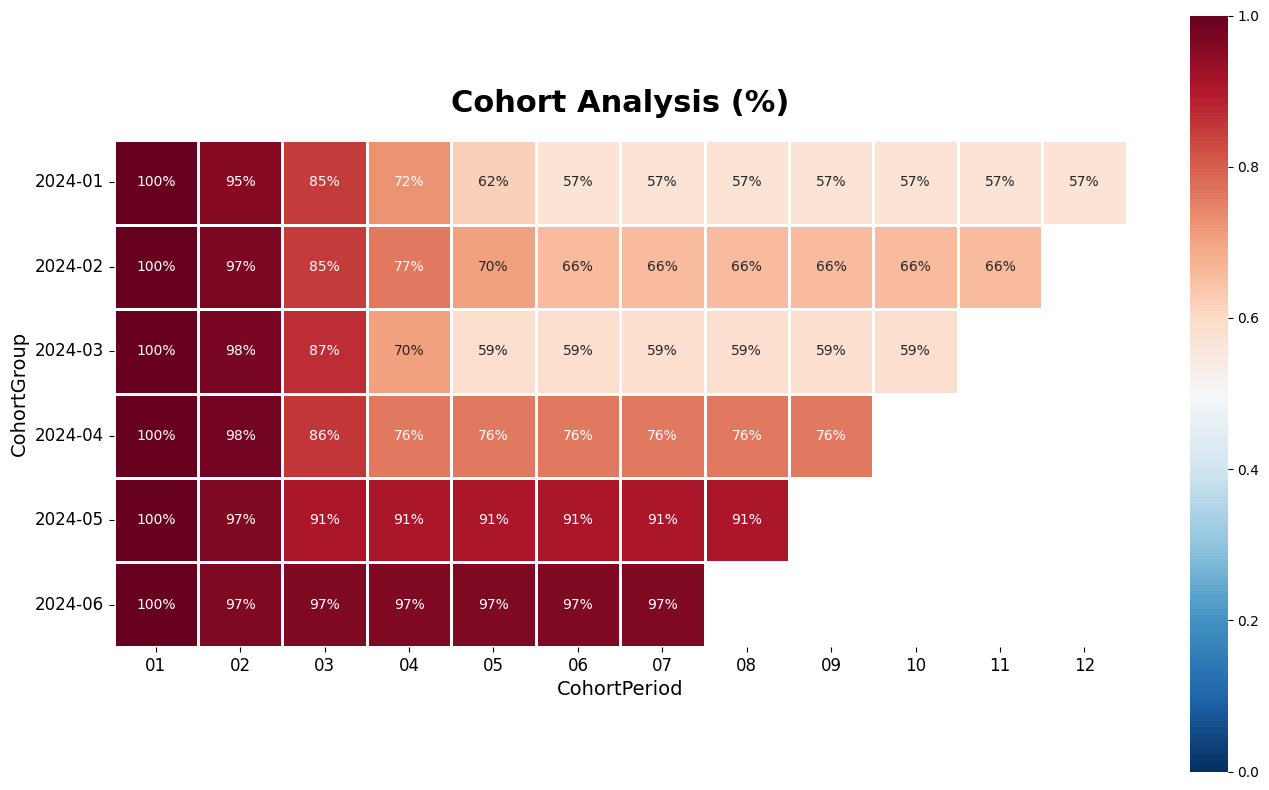

In [60]:

# Garantir que o index e colunas estejam no formato adequado
matriz_formatada = matriz_retencao.copy()
matriz_formatada.index = matriz_formatada.index.strftime('%Y-%m')  # remove T00:00...
matriz_formatada.columns.name = 'Período'
matriz_formatada.columns = [f"{col+1:02}" for col in matriz_formatada.columns]
matriz_formatada.index.name = 'Mês de Referência'

plt.figure(figsize=(14, 8))

sns.heatmap(
    matriz_formatada,
    annot=True,
    fmt=".0%",
    cmap="RdBu_r",
    cbar=True,
    linewidths=1,
    linecolor='white',
    vmin=0, vmax=1,
    square=True  # ← Deixa cada célula em proporção quadrada
)

plt.title("Cohort Analysis (%)", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("CohortPeriod", fontsize=14)
plt.ylabel("CohortGroup", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

### O gráfico acima mostra a taxa de retenção dos clientes mês a mês após sua entrada. Ele indica o quão bem as coortes estão mantendo seus clientes ao longo do tempo.

*As cores vão do vermelho escuro (alta retenção) ao branco (baixa), e cada linha representa uma coorte (grupo de clientes que entrou no mesmo mês). As colunas representam os meses desde a entrada (CohortPeriod).*

**Podemos perceber que a primeira grande queda ocorre no 2º ao 4º mês para coortes mais antigas (jan a mar/24):**

Coorte de Janeiro: cai de 100% → 72% em 3 meses.
Coorte de Março: de 100% → 59% em 4 meses.

🔎 *Sinal de problema no início do ciclo de vida.*

**Melhoria de retenção nas coortes recentes (mai e jun/24):**

Coorte de Maio mantém 91% até o 8º mês.
Junho retém 97% por 7 meses seguidos.

🟢 *Sugere melhoria nas estratégias de onboarding ou produto. Recomendo analisar o que foi feito de estratégia durantes esses meses.*

**🎯 Ações ou recomendações:**

Investigar os primeiros 3 meses de jornada: Onde a maioria abandona — avaliar onboarding, valor percebido, suporte.

Replicar práticas das coortes mais recentes: Algo mudou (ex: comunicação, bônus, melhorias?) que manteve mais clientes ativos.

Criar ações específicas de engajamento nos meses críticos (2 a 4): Pushs, ofertas, onboarding reforçado.

Monitorar se as coortes recentes mantêm a boa retenção com o tempo.





Média de tempo de retenção: 7.57 meses
Mediana de tempo de retenção: 8.00 meses


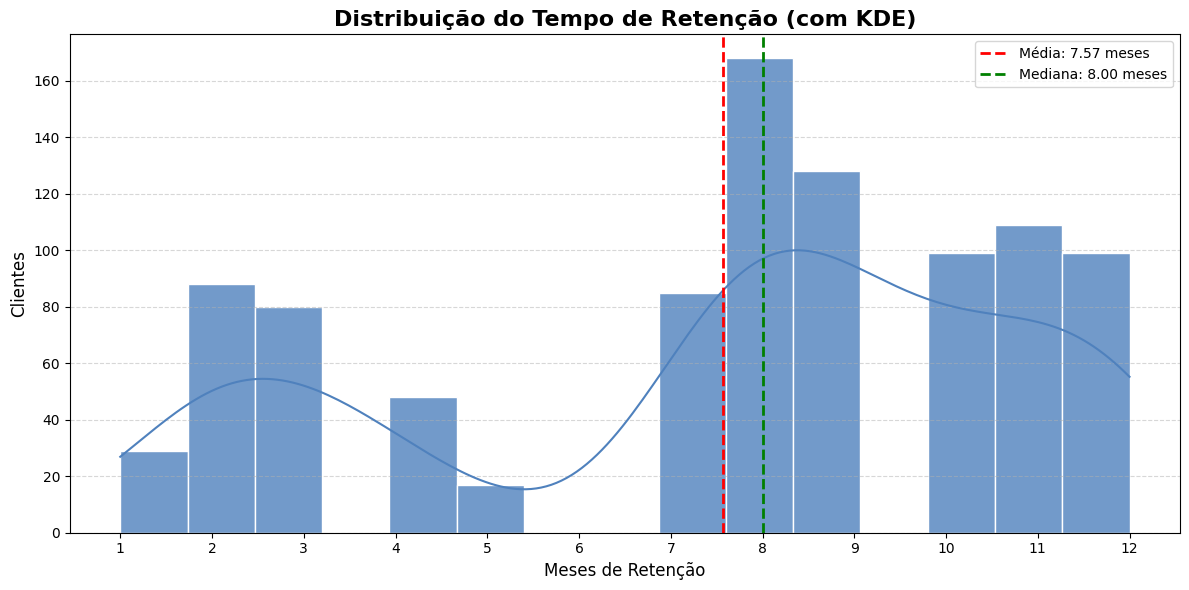

In [63]:
# Calcular tempo máximo de retenção por cliente
tempo_por_cliente = df_expansao.groupby('id_cliente')['mes_relativo'].max() + 1  # ⬅️ Aqui somamos +1

# Calcular média e mediana
media_tempo = tempo_por_cliente.mean()
mediana_tempo = tempo_por_cliente.median()

# Mostrar os valores
print(f"Média de tempo de retenção: {media_tempo:.2f} meses")
print(f"Mediana de tempo de retenção: {mediana_tempo:.2f} meses")

plt.figure(figsize=(12, 6))
sns.histplot(tempo_por_cliente, kde=True, color="#4F81BD", bins=15, edgecolor="white", alpha=0.8)

# Linhas de média e mediana
plt.axvline(media_tempo, color='red', linestyle='--', linewidth=2, label=f'Média: {media_tempo:.2f} meses')
plt.axvline(mediana_tempo, color='green', linestyle='--', linewidth=2, label=f'Mediana: {mediana_tempo:.2f} meses')

# Estética
plt.title("Distribuição do Tempo de Retenção (com KDE)", fontsize=16, fontweight='bold')
plt.xlabel("Meses de Retenção", fontsize=12)
plt.ylabel("Clientes", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(range(1, tempo_por_cliente.max() + 1))  # ← força ticks de 1 até o valor máximo
plt.tight_layout()
plt.show()



### O Histograma com curva de densidade (KDE) apresenta a distribuição de tempo de vida dos clientes em meses, ou seja, por quanto tempo os clientes permanecem ativos antes de cancelarem ou inativarem.

*A linha vermelha representa a média e a linha verde a mediana do tempo de retenção.*

Podemos perceber que a retenção média e a mediana são altas. Média ≈ 7,6 meses, Mediana ≈ 8 meses.
✅ Sinal positivo: mais da metade dos clientes permanece por até 8 meses.

**Temos uma distribuição bimodal:**

Um pico nos primeiros meses (1 a 3) e outro pico entre 8 a 12 meses.
🔍 Isso indica dois comportamentos distintos: clientes que saem rapidamente e clientes que permanecem bastante tempo. Reforçando o que identificamos no primeiro gráfico.

🎯 **O que este gráfico sugere:**
A base fiel de clientes tem comportamento robusto — vale a pena estudar esse grupo para entender o que os mantém.

Pode ser interessante segmentar estratégias: uma para novos clientes (ativação) e outra para clientes longevos (recompensa, upsell, fidelização).




In [78]:
!pip install lifelines
from lifelines import KaplanMeierFitter


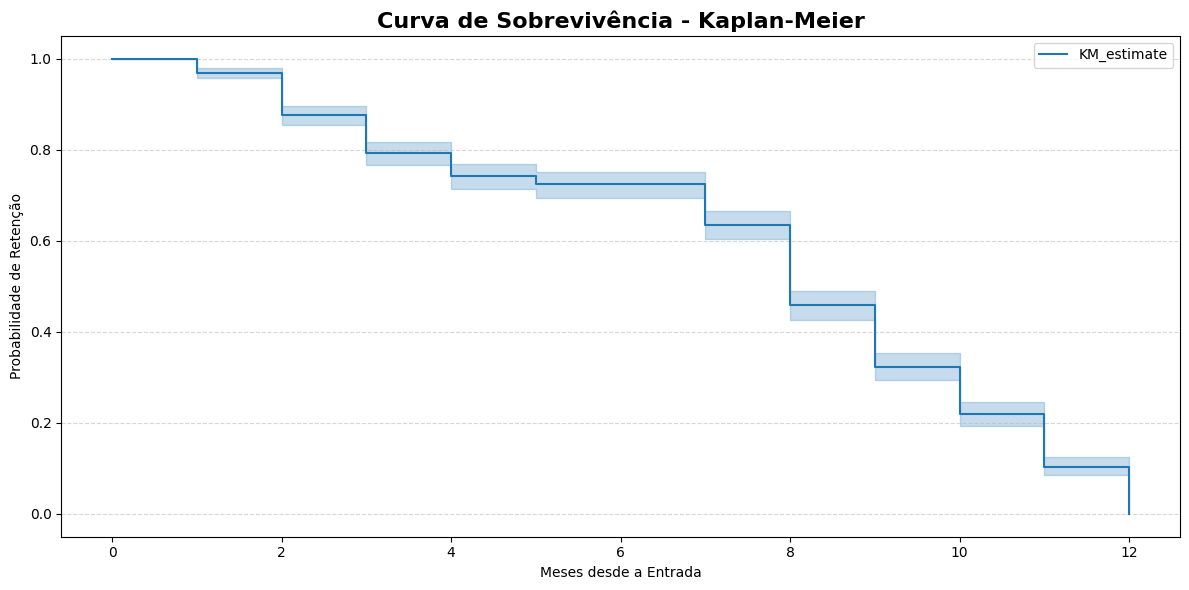

In [79]:
# Obter o tempo de retenção final por cliente
tempo_vida = df_expansao.groupby('id_cliente')['mes_relativo'].max().reset_index()
tempo_vida['meses_ativos'] = tempo_vida['mes_relativo'] + 1  # Ajustar M0 → mês 1

# Supondo que todos os clientes saíram (sem censura)
tempo_vida['evento_ocorreu'] = True  # 1 para evento (churn)

kmf = KaplanMeierFitter()
kmf.fit(durations=tempo_vida['meses_ativos'], event_observed=tempo_vida['evento_ocorreu'])

plt.figure(figsize=(12, 6))
kmf.plot(ci_show=True)
plt.title("Curva de Sobrevivência - Kaplan-Meier", fontsize=16, fontweight='bold')
plt.xlabel("Meses desde a Entrada")
plt.ylabel("Probabilidade de Retenção")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Esse gráfico mostra a Curva de Sobrevivência dos clientes usando o método Kaplan-Meier, que é comumente utilizado em análises de churn e tempo de vida de clientes.

*Eixo X: Meses desde a entrada do cliente (tempo desde o início da assinatura).
Eixo Y: Probabilidade acumulada de um cliente ainda estar ativo (não ter churnado) até aquele mês.*

Podemos perceber que o Churn precoce é crítico, visto que a maioria dos clientes são perdidos nos primeiros meses e a retenção de longo prazo é baixa, já que a maior parte dos clientes não permanecem por mais de 12 meses.

**Ações estruturadas nos primeiros meses podem ter grande impacto no LTV e retenção geral. Recomendo focar no onboarding e engajamento nos 3 primeiros meses e analisar a causa inicial desses chur para definir ações, criando campanhas de retenção específicas.**



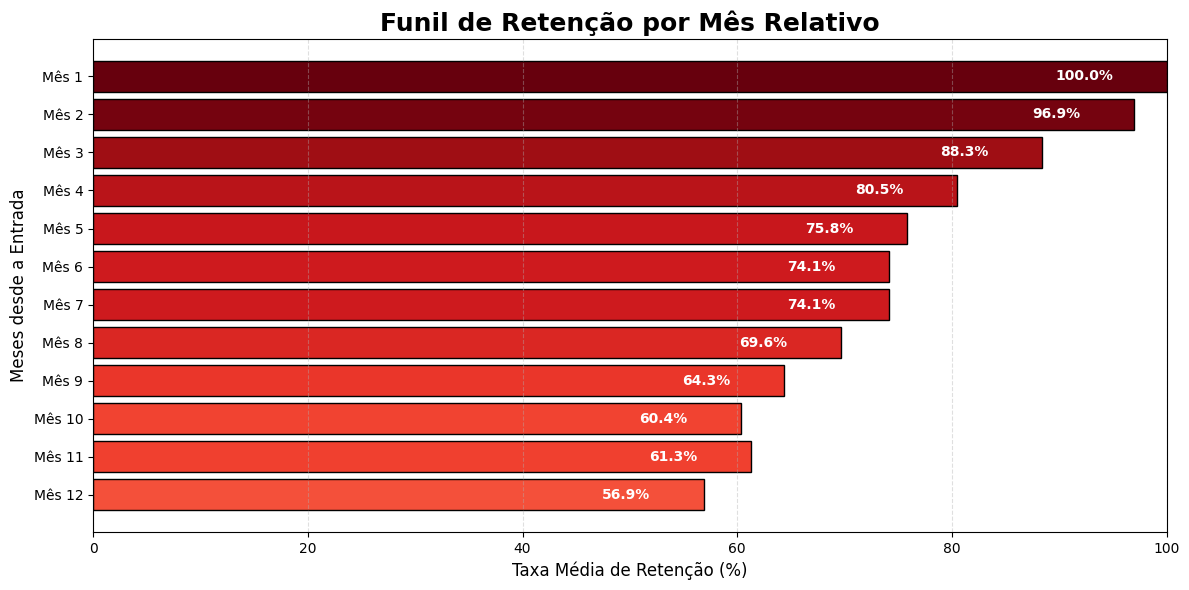

In [81]:
# Converter valores para porcentagem média de retenção por mês relativo
retencao_media_por_mes = matriz_retencao.mean().sort_index() * 100

# Plotar o gráfico de funil horizontal
plt.figure(figsize=(12, 6))
bars = plt.barh(
    y=[f"Mês {i+1}" for i in retencao_media_por_mes.index],
    width=retencao_media_por_mes.values,
    color=plt.cm.Reds(retencao_media_por_mes.values / 100),
    edgecolor='black'
)

# Adicionar os valores nas barras
for bar in bars:
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.1f}%", va='center', ha='right',
             fontsize=10, color='white', fontweight='bold')

# Estética
plt.title("Funil de Retenção por Mês Relativo", fontsize=18, fontweight='bold')
plt.xlabel("Taxa Média de Retenção (%)", fontsize=12)
plt.ylabel("Meses desde a Entrada", fontsize=12)
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.gca().invert_yaxis()  # Inverter eixo para parecer um funil
plt.tight_layout()
plt.show()


### Esse gráfico representa um Funil de Retenção por Mês Relativo, também conhecido como Retention Funnel. Ele mostra, mês a mês desde a entrada do cliente, qual a porcentagem média de clientes ainda ativos.

*Eixo Y (vertical): Meses desde a entrada do cliente (mês 1 = entrada).*

*Eixo X (horizontal): Taxa média de retenção em cada mês.*

*Barras horizontais: Representam a porcentagem média de clientes que permanecem ativos no mês correspondente.*

Esse gráfico evidencia o que já vimos em nossa análise, por exemplo, que temos uma perda significativa nos primeiros meses, de 100% no mês 1 para 88,3% já no mês 3, indicando uma perda de ~12% em apenas 2 meses.

No mês 4, a retenção já está em 80,5% → é um sinal de que os primeiros 3–4 meses são críticos para o churn.

Entretanto, temos leve estabilização entre os meses 5 e 7, Pequenas quedas (de 75,8% para 74,1%) mostram que quem passou do mês 4 tende a permanecer por mais tempo e retornamos a queda significativa entre os meses 8 e 10, de modo que ao fim de 1 ano, apenas 56,9% dos clientes ainda estão ativos em média.

**Sendo assim, temos o reforço de que Onboarding e engajamento nos primeiros 3 meses são essenciais. Além disso, clientes que passam do mês 4 têm mais propensão a se manter, então esse é o momento ideal para oferecer planos de fidelização, upgrades ou recompensas.**

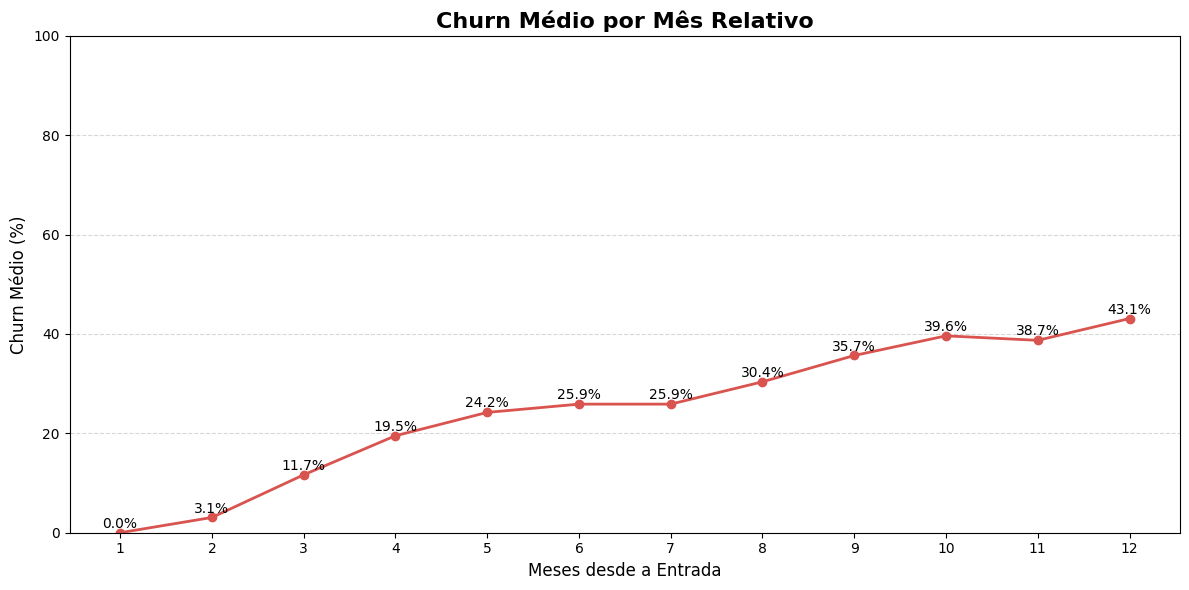

In [82]:
# Calcular taxa de churn como complemento da taxa de retenção
churn_por_mes = 1 - matriz_retencao.mean().sort_index()

# Converter para porcentagem
churn_por_mes_percent = churn_por_mes * 100

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(
    churn_por_mes_percent.index + 1,  # ajusta Mês 0 para Mês 1
    churn_por_mes_percent.values,
    marker='o', linestyle='-', color='#D9534F', linewidth=2
)

# Adicionar valores nas marcações
for i, value in enumerate(churn_por_mes_percent.values):
    plt.text(i + 1, value + 1, f"{value:.1f}%", ha='center', fontsize=10)

# Estética
plt.title("Churn Médio por Mês Relativo", fontsize=16, fontweight='bold')
plt.xlabel("Meses desde a Entrada", fontsize=12)
plt.ylabel("Churn Médio (%)", fontsize=12)
plt.xticks(range(1, len(churn_por_mes_percent) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


### O gráfico acima mostra o Churn Médio por Mês Relativo, ou seja, a percentual acumulada de clientes que cancelaram ao longo dos meses desde a entrada na base.

*Eixo X: Meses desde a entrada do cliente (mês 1 = entrada).*

*Eixo Y: Porcentagem média de churn acumulado (%).*

Novamente identificamos abandono precore até o mês 3, talvez por falta de engajamento, onboarding ruim ou expectativas não atendidas. Então precisamos identificar isso (analisando a pesquisa de cancelamento) para seguir com o plano de ação adequado.

A curva é crescente e contínua, o que é típico de churn acumulado, mas a inclinação mostra onde as maiores perdas ocorrem.

📌Então concluímos essa análise com as seguintes sugestões:

**1. Atuação rápida nos primeiros 3 meses:**

Reforçar onboarding, comunicação de valor e benefícios.

Incentivos de retenção (descontos, conteúdo exclusivo, bônus).

**2. Upgrade e fidelização entre o 4° e 5° mês:**

Clientes que passam do mês 4 têm mais propensão a se manter, como identificamos no funil de retenção, então esse é o momento ideal para oferecer planos de fidelização, upgrades ou recompensas.

**3. Monitoramento nos meses 6 a 9:**

Investigar gatilhos de churn (pesquisa, comportamento).

Implementar estratégias de reengajamento (notificações, atualizações, promoções).


**4. Benchmarking:**

Se o churn anual acima de 40% for alto comparado ao seu mercado, é um sinal claro de alerta.

